# analyzing high magnification data

This notebook shows some basic analysis of high magnification mesoscope data.

## setup plotting

In [1]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import matplotlib.pyplot as plt
%matplotlib inline

## import our packages

In [2]:
import thunder as td
from showit import image, tile

## load the data

In [3]:
data = td.images.fromtif('../data/highmag/images/')

Inspect the data to see the `dtype` and `shape`. This is a greatly reduced subset of the full dataset: it's one field out of four, and it's been downsampled in time.

In [4]:
data

Images
mode: local
dtype: uint8
shape: (50, 512, 512)

Look at the mean image.

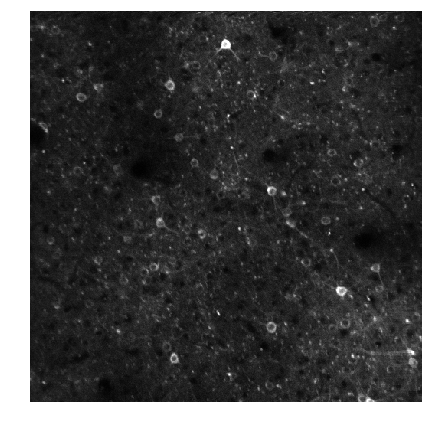

In [5]:
image(data.mean(), clim=(0, 100), size=7);

## perform registration

We're going to perform some very simple image registration.

First, we'll need a reference image, let's use the mean.

In [6]:
reference = data.mean().toarray()

Now import the algorithm.

In [7]:
from registration import CrossCorr
algorithm = CrossCorr()

And fit it to the data.

In [8]:
model = algorithm.fit(data, reference)

We can inspect the resulting model

In [9]:
model

RegistrationModel
length: 50
algorithm: CrossCorr

And plot it as an array to see the shifts in x and y

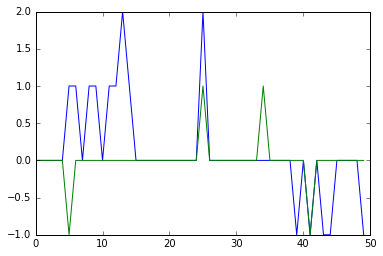

In [10]:
plt.plot(model.toarray());

Now use the model to transform our data.

In [11]:
registered = model.transform(data)

If we look at the mean of the registered data and the reference side by side, the left should look sharper.

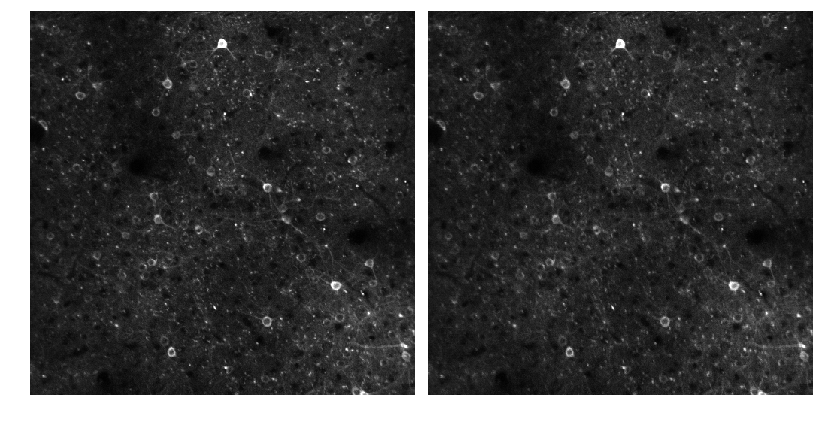

In [12]:
tile([registered.mean(), reference], size=14, clim=(0, 100));

## extract neurons 

Neuron masks were already defined manually for these data, so we can load them from a file.

In [13]:
from extraction import load
model = load('../data/highmag/regions/regions.json')

Show the masks on top of the mean of the registered data.

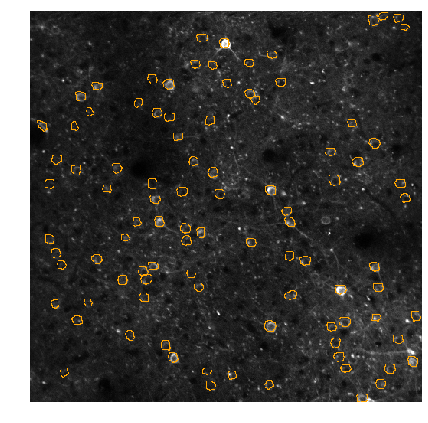

In [14]:
base = (registered.mean().toarray()/100).clip(0,1)
overlay = model.regions.mask(base=base, stroke='orange', fill = None)
image(overlay, size = 7);

And now use the model's transform to extract the neuron time series.

In [15]:
traces = model.transform(registered)

First plot the raw flouresence values

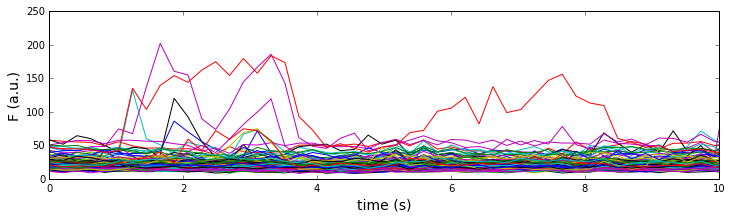

In [16]:
time = [float(x)/4.83 for x in range(traces.shape[2])]
plt.figure(figsize=[12,3])
plt.plot(time, traces.toarray().T);
plt.xlim([0, 10])
plt.xlabel('time (s)', fontsize=14);
plt.ylabel('F (a.u.)', fontsize=14);

Now we can use a series method to normalize, in this case using a rolling window of length 25

In [17]:
processed = traces.normalize('window', window=25)

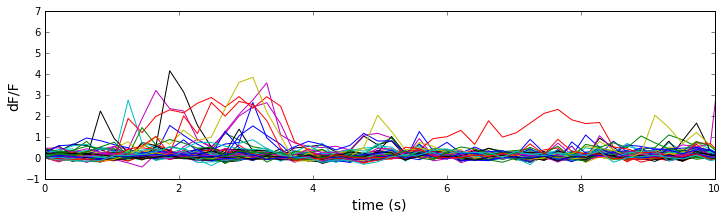

In [18]:
plt.figure(figsize=[12,3])
plt.plot(time, processed.toarray().T);
plt.xlim([0, 10])
plt.xlabel('time (s)', fontsize=14);
plt.ylabel('dF/F', fontsize=14);